In [2]:
import pandas as pd
#train 1
input_file = "input/train/train.csv"
dataset = pd.read_csv(input_file)
df = pd.DataFrame(dataset)
cols = [3, 21]
df = df[df.columns[cols]]
df.head()

,Breed1,PetID
0,265,0008c5398
1,307,000a290e4
2,307,000fb9572
3,241,0011d7c25
4,307,00156db4a


In [3]:
#test 1
test_input_file = "input/test/test.csv"
testdataset = pd.read_csv(test_input_file)
dft = pd.DataFrame(testdataset)
cols = [3, 21]
dft = dft[dft.columns[cols]]
dft.head()

,Breed1,PetID
0,307,378fcc4fc
1,266,73c10e136
2,266,72000c4c5
3,266,e147a4b9f
4,307,43fbba852


In [4]:
input_file2 = "input/breed_labels.csv"
dataset2 = pd.read_csv(input_file2)
df2 = pd.DataFrame(dataset2)
cols = [0, 2]
df2 = df2[df2.columns[cols]]
df2.head()

,BreedID,BreedName
0,1,Affenpinscher
1,2,Afghan Hound
2,3,Airedale Terrier
3,4,Akbash
4,5,Akita


In [5]:
df.rename(columns = {'Breed1':'BreedID'}, inplace = True)
df.head()

,BreedID,PetID
0,265,0008c5398
1,307,000a290e4
2,307,000fb9572
3,241,0011d7c25
4,307,00156db4a


In [6]:
dft.rename(columns = {'Breed1':'BreedID'}, inplace = True)
dft.head()

,BreedID,PetID
0,307,378fcc4fc
1,266,73c10e136
2,266,72000c4c5
3,266,e147a4b9f
4,307,43fbba852


In [7]:
#train
combo = pd.merge(df, df2, on = ['BreedID'], how = 'right')
combo.head()

,BreedID,PetID,BreedName
0,265,0008c5398,Domestic Medium Hair
1,265,001a1aaad,Domestic Medium Hair
2,265,0025a8313,Domestic Medium Hair
3,265,00b00d5c1,Domestic Medium Hair
4,265,00be0a63e,Domestic Medium Hair


In [8]:
#train
combo.drop(['BreedID'], axis=1, inplace=True)
combo.head()

,PetID,BreedName
0,0008c5398,Domestic Medium Hair
1,001a1aaad,Domestic Medium Hair
2,0025a8313,Domestic Medium Hair
3,00b00d5c1,Domestic Medium Hair
4,00be0a63e,Domestic Medium Hair


In [9]:
#test
testcombo = pd.merge(dft, df2, on = ['BreedID'], how = 'right')
testcombo.head()

,BreedID,PetID,BreedName
0,307,378fcc4fc,Mixed Breed
1,307,43fbba852,Mixed Breed
2,307,77a490ec9,Mixed Breed
3,307,d1eada628,Mixed Breed
4,307,4e21958c3,Mixed Breed


In [10]:
testcombo.drop(['BreedID'], axis=1, inplace=True)
testcombo.head()

,PetID,BreedName
0,378fcc4fc,Mixed Breed
1,43fbba852,Mixed Breed
2,77a490ec9,Mixed Breed
3,d1eada628,Mixed Breed
4,4e21958c3,Mixed Breed


In [11]:
import cv2
import numpy as np
import os
from tqdm import tqdm, tqdm_notebook
from keras.applications.densenet import preprocess_input, DenseNet121
import tensorflow as tf
import sys

img_size = 256

def resize_to_square(im):
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im

def load_image(path, pet_id):
    image = cv2.imread(f'{path}{pet_id}-1.jpg')
    new_image = resize_to_square(image)
    new_image = preprocess_input(new_image)
    return new_image


Using TensorFlow backend.


In [12]:
path = "input/train/cropped_images/"
graypath = "input/sorted/"
csvpath = "input/train/train.csv"

def loadImages(img_preview=0, sizex=256, sizey=256):
    if not os.path.exists(path):
        os.mkdir(path)
    if not os.path.exists(graypath):
        os.mkdir(graypath)  

    valid_types = [".jpg",".gif",".png",".tga"]
    #i = 0
    for f in tqdm_notebook(os.listdir(path), desc='sorting Progress'):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_types:
            return
        n = f.split("-")[0]
        
        #print(combo.loc[combo['PetID'] == n, 'BreedName'].item())
        try:
            #cc = combo.set_index(['BreedName'])
            #print(cc.loc[n])
            #bn = cc.loc[n]
            bn = combo.loc[combo['PetID'] == n, 'BreedName'].item()
            
            if os.path.exists(graypath + bn + "/"):
                if not os.path.isfile(graypath + bn + "/" + f):
                    image = cv2.imread(path+"/"+f) #pass in 0 as second parameter to automatically convert to grayscale
                    if image is not None:
                        image = cv2.resize(image, dsize=(sizex, sizey), interpolation = cv2.INTER_CUBIC)
                        if not os.path.isfile(graypath + bn + "/" + f):
                            cv2.imwrite(graypath + bn + "/" + f, image)
                            print("\rCreated File: " + graypath + bn + "/" + f, end='')
        except:
            pass
    return

def makeDirectories():
    if not os.path.exists(path):
        os.mkdir(path)
    if not os.path.exists(graypath):
        os.mkdir(graypath)
    
    for breed in tqdm_notebook(df2['BreedName'].unique(), desc='Directory Labelling Progress'):
        if not os.path.exists(graypath + breed + "/"):
            print(graypath + breed + '/');
            os.mkdir(graypath + breed + "/")
            print("\rCreated Directory: " + graypath + breed + "/", end='')    
    return

In [294]:
def removeEmptyFolders(folderpath="input/sorted/"):
    for folder in tqdm_notebook(os.listdir(folderpath), desc='Empty folder deletion Progress'):
        if os.path.exists(folderpath + folder):
            if next(os.scandir(folderpath + folder), None) is None:
                print("\rRemoving empty folder: " + folder + "\tfrom: " + folderpath)
                os.rmdir(folderpath + folder)
return



In [296]:
makeDirectories()

input/sorted/Affenpinscher/
Created Directory: input/sorted/Affenpinscher/input/sorted/Afghan Hound/
Created Directory: input/sorted/Afghan Hound/input/sorted/Airedale Terrier/
Created Directory: input/sorted/Airedale Terrier/input/sorted/Akbash/
Created Directory: input/sorted/Akbash/input/sorted/Akita/
Created Directory: input/sorted/Akita/input/sorted/Alaskan Malamute/
Created Directory: input/sorted/Alaskan Malamute/input/sorted/American Bulldog/
Created Directory: input/sorted/American Bulldog/input/sorted/American Eskimo Dog/
Created Directory: input/sorted/American Eskimo Dog/input/sorted/Abyssinian/
Created Directory: input/sorted/Abyssinian/input/sorted/American Curl/
Created Directory: input/sorted/American Curl/


In [ ]:
loadImages()


### TEST ###

In [14]:
tpath = "input/test/test_images/"
tgraypath = "input/sortedtest/"

def test_loadImages(img_preview=0, sizex=256, sizey=256):
    if not os.path.exists(tpath):
        os.mkdir(tpath)
    if not os.path.exists(tgraypath):
        os.mkdir(tgraypath)  

    valid_types = [".jpg",".gif",".png",".tga"]
    #i = 0
    for f in tqdm_notebook(os.listdir(tpath), desc='sorting Progress'):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_types:
            return
        n = f.split("-")[0]
        
        #print(combo.loc[combo['PetID'] == n, 'BreedName'].item())
        try:
            bn = testcombo.loc[testcombo['PetID'] == n, 'BreedName'].item()
        
            if os.path.exists(tgraypath + bn + "/"):
                if not os.path.isfile(tgraypath + bn + "/" + f):
                    if os.path.isfile(tpath + "/" + f):
                        image = cv2.imread(tpath+"/"+f) #pass in 0 as second parameter to automatically convert to grayscale
                        if image is not None:
                            image = cv2.resize(image, dsize=(sizex, sizey), interpolation = cv2.INTER_CUBIC)
                            if not os.path.isfile(tgraypath + bn + "/" + f):
                                cv2.imwrite(tgraypath + bn + "/" + f, image)
                                print("\rCreated File: " + tgraypath + bn + "/" + f, end='')
        except:
            pass
    return

def test_makeDirectories():
    if not os.path.exists(tpath):
        os.mkdir(tpath)
    if not os.path.exists(tgraypath):
        os.mkdir(tgraypath)
    
    for breed in tqdm_notebook(df2['BreedName'].unique(), desc='Directory Labelling Progress'):
        if not os.path.exists(tgraypath + breed + "/"):
            print(tgraypath + breed + '/');
            os.mkdir(tgraypath + breed + "/")
            print("\rCreated Directory: " + tgraypath + breed + "/", end='')    
    return

In [15]:
test_makeDirectories()

input/sortedtest/Affenpinscher/
Created Directory: input/sortedtest/Affenpinscher/input/sortedtest/Airedale Terrier/
Created Directory: input/sortedtest/Airedale Terrier/input/sortedtest/Akbash/
Created Directory: input/sortedtest/Akbash/input/sortedtest/American Eskimo Dog/
Created Directory: input/sortedtest/American Eskimo Dog/input/sortedtest/American Hairless Terrier/
Created Directory: input/sortedtest/American Hairless Terrier/input/sortedtest/American Water Spaniel/
Created Directory: input/sortedtest/American Water Spaniel/input/sortedtest/Anatolian Shepherd/
Created Directory: input/sortedtest/Anatolian Shepherd/input/sortedtest/Appenzell Mountain Dog/
Created Directory: input/sortedtest/Appenzell Mountain Dog/input/sortedtest/Australian Kelpie/
Created Directory: input/sortedtest/Australian Kelpie/input/sortedtest/Australian Shepherd/
Created Directory: input/sortedtest/Australian Shepherd/input/sortedtest/Bearded Collie/
Created Directory: input/sortedtest/Bearded Collie/in

In [16]:
test_loadImages()

In [295]:
#removeEmptyFolders()
#removeEmptyFolders(folderpath="input/sortedtest/")

In [284]:
import tensorflow as tf
tf.test.gpu_device_name()



'/device:GPU:0'

In [19]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(combo, test_size=0.2)

In [20]:
train.head()

,PetID,BreedName
11559,ca21c4266,Persian
13346,5188ce75b,Collie
7546,22937e80e,Domestic Short Hair
10532,f6f2f9424,Domestic Short Hair
12587,818df5a9f,Tortoiseshell


In [21]:
test.head()

,PetID,BreedName
9555,b501efb71,Domestic Short Hair
2811,474db10df,Mixed Breed
9597,b7d2f8186,Domestic Short Hair
8573,6f77b4edf,Domestic Short Hair
605,7f1bb8d32,Domestic Medium Hair


In [22]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K

jobs = 44
config = tf.ConfigProto(intra_op_parallelism_threads=jobs, \
                        inter_op_parallelism_threads=jobs, \
                        allow_soft_placement=True, \
                        device_count = {'CPU': jobs})
session = tf.Session(config=config)
K.set_session(session)

In [23]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [24]:
CLASSES = 307
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [25]:
for layer in base_model.layers:
    layer.trainable = False

In [26]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [28]:
BATCH_SIZE = 32
train_generator = train_datagen.flow_from_directory(
    'input/sorted',  # this is the target directory
    target_size=(256,256),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 57108 images belonging to 307 classes.


In [29]:
val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
    'input/sortedtest',
    target_size=(256,256), 
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 15040 images belonging to 307 classes.


In [30]:
from keras.preprocessing import image
EPOCHS = 5
BATCH_SIZE = 32
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64
MODEL_FILE = 'classifier_model.model'
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/5


204/320 [==================>...........] - ETA: 1:05:44 - loss: 5.8018 - acc: 0.0000e+ - ETA: 33:11 - loss: 4.5924 - acc: 0.1094     - ETA: 22:19 - loss: 4.0625 - acc: 0.19 - ETA: 16:53 - loss: 3.6724 - acc: 0.25 - ETA: 13:38 - loss: 3.6714 - acc: 0.26 - ETA: 11:41 - loss: 3.3083 - acc: 0.32 - ETA: 10:06 - loss: 3.1981 - acc: 0.33 - ETA: 8:55 - loss: 3.1274 - acc: 0.3438 - ETA: 7:59 - loss: 3.1549 - acc: 0.343 - ETA: 7:25 - loss: 3.1093 - acc: 0.359 - ETA: 7:11 - loss: 3.0586 - acc: 0.358 - ETA: 6:59 - loss: 3.0157 - acc: 0.356 - ETA: 6:44 - loss: 2.9787 - acc: 0.363 - ETA: 6:31 - loss: 2.9931 - acc: 0.359 - ETA: 6:21 - loss: 2.9490 - acc: 0.368 - ETA: 6:12 - loss: 2.9412 - acc: 0.373 - ETA: 6:03 - loss: 2.9190 - acc: 0.378 - ETA: 5:59 - loss: 2.9366 - acc: 0.381 - ETA: 5:58 - loss: 2.8876 - acc: 0.386 - ETA: 5:55 - loss: 2.8754 - acc: 0.392 - ETA: 5:53 - loss: 2.8575 - acc: 0.397 - ETA: 5:48 - loss: 2.8710 - acc: 0.393 - ETA: 5:45 - loss: 2.8380 - acc: 0.400 - ETA: 5:39 - loss: 2.7956

D:\Users\Sunfl\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.161696). Check your callbacks.
  % delta_t_median)


205/320 [==================>...........] - ETA: 1:25 - loss: 2.0308 - acc: 0.562 - ETA: 1:13 - loss: 2.0668 - acc: 0.510 - ETA: 1:07 - loss: 1.9512 - acc: 0.546 - ETA: 1:02 - loss: 1.8818 - acc: 0.562 - ETA: 1:03 - loss: 1.9101 - acc: 0.567 - ETA: 1:00 - loss: 1.9280 - acc: 0.558 - ETA: 59s - loss: 1.8813 - acc: 0.574 - ETA: 1:04 - loss: 1.7983 - acc: 0.593 - ETA: 1:03 - loss: 1.8355 - acc: 0.575 - ETA: 1:02 - loss: 1.8379 - acc: 0.571 - ETA: 1:02 - loss: 1.7673 - acc: 0.591 - ETA: 1:07 - loss: 1.7247 - acc: 0.598 - ETA: 1:27 - loss: 1.7792 - acc: 0.591 - ETA: 1:39 - loss: 1.7607 - acc: 0.595 - ETA: 1:47 - loss: 1.7585 - acc: 0.591 - ETA: 1:54 - loss: 1.8168 - acc: 0.580 - ETA: 2:00 - loss: 1.8609 - acc: 0.576 - ETA: 2:05 - loss: 1.8684 - acc: 0.574 - ETA: 2:11 - loss: 1.8799 - acc: 0.564 - ETA: 2:15 - loss: 1.8636 - acc: 0.567 - ETA: 2:19 - loss: 1.8718 - acc: 0.569 - ETA: 2:23 - loss: 1.8695 - acc: 0.567 - ETA: 2:26 - loss: 1.8524 - acc: 0.570 - ETA: 2:28 - loss: 1.8279 - acc: 0.573 

320/320 [==============================] - ETA: 1:24 - loss: 2.0436 - acc: 0.559 - ETA: 1:23 - loss: 2.0432 - acc: 0.559 - ETA: 1:23 - loss: 2.0425 - acc: 0.559 - ETA: 1:22 - loss: 2.0461 - acc: 0.559 - ETA: 1:21 - loss: 2.0441 - acc: 0.559 - ETA: 1:21 - loss: 2.0453 - acc: 0.559 - ETA: 1:20 - loss: 2.0447 - acc: 0.559 - ETA: 1:19 - loss: 2.0449 - acc: 0.559 - ETA: 1:18 - loss: 2.0461 - acc: 0.559 - ETA: 1:18 - loss: 2.0437 - acc: 0.560 - ETA: 1:17 - loss: 2.0377 - acc: 0.561 - ETA: 1:16 - loss: 2.0362 - acc: 0.561 - ETA: 1:15 - loss: 2.0349 - acc: 0.561 - ETA: 1:15 - loss: 2.0325 - acc: 0.561 - ETA: 1:14 - loss: 2.0319 - acc: 0.562 - ETA: 1:13 - loss: 2.0291 - acc: 0.562 - ETA: 1:13 - loss: 2.0294 - acc: 0.562 - ETA: 1:12 - loss: 2.0299 - acc: 0.562 - ETA: 1:11 - loss: 2.0313 - acc: 0.563 - ETA: 1:10 - loss: 2.0330 - acc: 0.562 - ETA: 1:10 - loss: 2.0367 - acc: 0.561 - ETA: 1:09 - loss: 2.0385 - acc: 0.562 - ETA: 1:08 - loss: 2.0387 - acc: 0.561 - ETA: 1:07 - loss: 2.0418 - acc: 0.561

205/320 [==================>...........] - ETA: 48s - loss: 1.7797 - acc: 0.56 - ETA: 1:07 - loss: 2.5928 - acc: 0.500 - ETA: 1:03 - loss: 2.4743 - acc: 0.479 - ETA: 59s - loss: 2.1522 - acc: 0.500 - ETA: 57s - loss: 2.2490 - acc: 0.48 - ETA: 57s - loss: 2.3450 - acc: 0.47 - ETA: 57s - loss: 2.1867 - acc: 0.48 - ETA: 57s - loss: 2.1125 - acc: 0.49 - ETA: 1:01 - loss: 2.0699 - acc: 0.506 - ETA: 1:00 - loss: 2.0685 - acc: 0.528 - ETA: 59s - loss: 2.1038 - acc: 0.528 - ETA: 58s - loss: 2.0977 - acc: 0.53 - ETA: 1:08 - loss: 2.0807 - acc: 0.538 - ETA: 1:31 - loss: 2.0752 - acc: 0.542 - ETA: 1:49 - loss: 2.0938 - acc: 0.539 - ETA: 2:02 - loss: 2.1030 - acc: 0.543 - ETA: 2:09 - loss: 2.1311 - acc: 0.546 - ETA: 2:16 - loss: 2.0898 - acc: 0.552 - ETA: 2:21 - loss: 2.0854 - acc: 0.541 - ETA: 2:26 - loss: 2.1033 - acc: 0.535 - ETA: 2:30 - loss: 2.1093 - acc: 0.537 - ETA: 2:34 - loss: 2.0942 - acc: 0.542 - ETA: 2:38 - loss: 2.0747 - acc: 0.540 - ETA: 2:41 - loss: 2.0359 - acc: 0.549 - ETA: 2:44 -

205/320 [==================>...........] - ETA: 48s - loss: 3.4155 - acc: 0.37 - ETA: 1:03 - loss: 2.5797 - acc: 0.468 - ETA: 1:00 - loss: 2.2828 - acc: 0.531 - ETA: 56s - loss: 2.2252 - acc: 0.531 - ETA: 54s - loss: 2.0652 - acc: 0.55 - ETA: 53s - loss: 2.2091 - acc: 0.54 - ETA: 52s - loss: 2.1845 - acc: 0.53 - ETA: 51s - loss: 2.2834 - acc: 0.52 - ETA: 52s - loss: 2.2395 - acc: 0.52 - ETA: 56s - loss: 2.2376 - acc: 0.51 - ETA: 55s - loss: 2.2732 - acc: 0.52 - ETA: 54s - loss: 2.2546 - acc: 0.52 - ETA: 1:05 - loss: 2.3112 - acc: 0.516 - ETA: 1:29 - loss: 2.2727 - acc: 0.506 - ETA: 1:49 - loss: 2.2669 - acc: 0.510 - ETA: 2:01 - loss: 2.2470 - acc: 0.513 - ETA: 2:09 - loss: 2.1678 - acc: 0.529 - ETA: 2:15 - loss: 2.1689 - acc: 0.533 - ETA: 2:21 - loss: 2.1852 - acc: 0.528 - ETA: 2:26 - loss: 2.1935 - acc: 0.528 - ETA: 2:30 - loss: 2.2191 - acc: 0.525 - ETA: 2:35 - loss: 2.2473 - acc: 0.521 - ETA: 2:38 - loss: 2.2278 - acc: 0.519 - ETA: 2:42 - loss: 2.2174 - acc: 0.520 - ETA: 2:44 - loss

320/320 [==============================] - ETA: 1:34 - loss: 2.0473 - acc: 0.554 - ETA: 1:33 - loss: 2.0469 - acc: 0.554 - ETA: 1:32 - loss: 2.0465 - acc: 0.554 - ETA: 1:31 - loss: 2.0443 - acc: 0.555 - ETA: 1:30 - loss: 2.0414 - acc: 0.555 - ETA: 1:30 - loss: 2.0408 - acc: 0.556 - ETA: 1:29 - loss: 2.0413 - acc: 0.556 - ETA: 1:28 - loss: 2.0469 - acc: 0.555 - ETA: 1:27 - loss: 2.0501 - acc: 0.554 - ETA: 1:26 - loss: 2.0489 - acc: 0.555 - ETA: 1:26 - loss: 2.0459 - acc: 0.555 - ETA: 1:25 - loss: 2.0429 - acc: 0.555 - ETA: 1:24 - loss: 2.0444 - acc: 0.556 - ETA: 1:23 - loss: 2.0425 - acc: 0.556 - ETA: 1:22 - loss: 2.0366 - acc: 0.557 - ETA: 1:21 - loss: 2.0374 - acc: 0.557 - ETA: 1:21 - loss: 2.0374 - acc: 0.556 - ETA: 1:20 - loss: 2.0395 - acc: 0.556 - ETA: 1:19 - loss: 2.0407 - acc: 0.555 - ETA: 1:18 - loss: 2.0389 - acc: 0.555 - ETA: 1:17 - loss: 2.0384 - acc: 0.555 - ETA: 1:17 - loss: 2.0351 - acc: 0.555 - ETA: 1:16 - loss: 2.0357 - acc: 0.555 - ETA: 1:15 - loss: 2.0387 - acc: 0.556

205/320 [==================>...........] - ETA: 49s - loss: 2.1828 - acc: 0.43 - ETA: 1:01 - loss: 2.7716 - acc: 0.484 - ETA: 58s - loss: 2.1872 - acc: 0.552 - ETA: 56s - loss: 1.9963 - acc: 0.60 - ETA: 57s - loss: 2.0137 - acc: 0.57 - ETA: 55s - loss: 2.0084 - acc: 0.55 - ETA: 54s - loss: 2.0682 - acc: 0.54 - ETA: 53s - loss: 2.0070 - acc: 0.55 - ETA: 1:00 - loss: 1.8896 - acc: 0.572 - ETA: 59s - loss: 1.8597 - acc: 0.571 - ETA: 57s - loss: 1.8513 - acc: 0.57 - ETA: 58s - loss: 1.9537 - acc: 0.57 - ETA: 1:10 - loss: 1.9295 - acc: 0.576 - ETA: 1:30 - loss: 1.9232 - acc: 0.573 - ETA: 1:45 - loss: 1.9992 - acc: 0.560 - ETA: 1:54 - loss: 2.0353 - acc: 0.556 - ETA: 2:03 - loss: 2.0411 - acc: 0.558 - ETA: 2:10 - loss: 2.0038 - acc: 0.569 - ETA: 2:16 - loss: 2.0141 - acc: 0.575 - ETA: 2:22 - loss: 2.0012 - acc: 0.581 - ETA: 2:26 - loss: 1.9795 - acc: 0.587 - ETA: 2:32 - loss: 1.9638 - acc: 0.586 - ETA: 2:36 - loss: 1.9655 - acc: 0.584 - ETA: 2:39 - loss: 1.9597 - acc: 0.582 - ETA: 2:42 - los

In [31]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
def predict(model, img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]
img = image.load_img('classify/tiny.jpg', target_size=(256, 256))
preds = predict(load_model(MODEL_FILE), img)

In [263]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from keras.preprocessing import image
from keras.models import load_model


def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("Mixed Breed", "Domestic Short Hair", "Domestic Medium Hair", "Tabby", "Domestic Long Hair"
             , "Siamese", "Persian", "Labrador Retriever", "Shih Tzu", "Poodle", "Terrier", "Golden Retriever",
            "Calico","German Shepherd Dog","American Shorthair","Spitz","Beagle","Rottweiler","Oriental Short Hair",
            "Bengal","Schnauzer","Miniature Pinscher","Jack Russell Terrier","Doberman Pinscher","Tuxedo","Cocker Spaniel",
            "Tortoiseshell","Dalmatian","Chihuahua","Husky","Border Collie","Bernese Mountain Dog")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot()
    plt.barh(len(preds), preds, alpha=0.5)
    plt.yticks([0, 9], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.imshow(preds)

In [75]:
model = load_model(MODEL_FILE)

In [91]:
# Bar graph showing count of pets in categories ranging from 0 to 4
#fig = plt.figure(figsize = (10,30))
#sns.countplot(y='BreedName', data=combo)
#print(combo.BreedName.value_counts())

[0.6732505  0.1759256  0.02946254 0.02251693 0.02104437]


TypeError: Invalid dimensions for image data

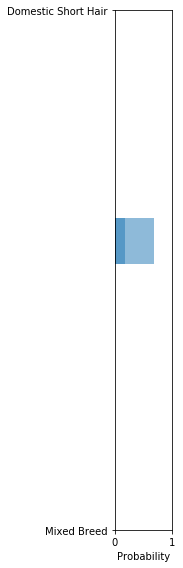

In [264]:
img = image.load_img('classify/tiny.jpg', target_size=(256, 256))
preds = predict(model, img)

p =preds[preds.argsort()[-5:]]
p[::-1].sort()
print(p)

plot_preds(np.asarray(img), p)
p

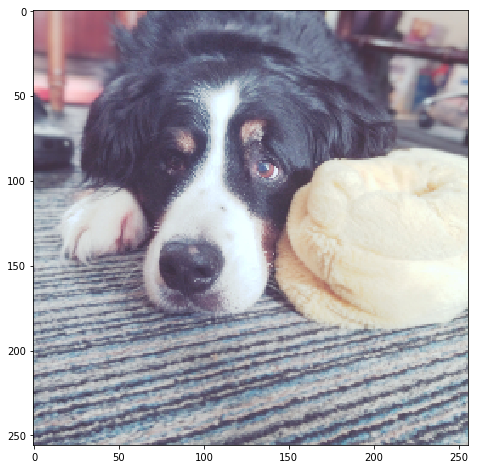

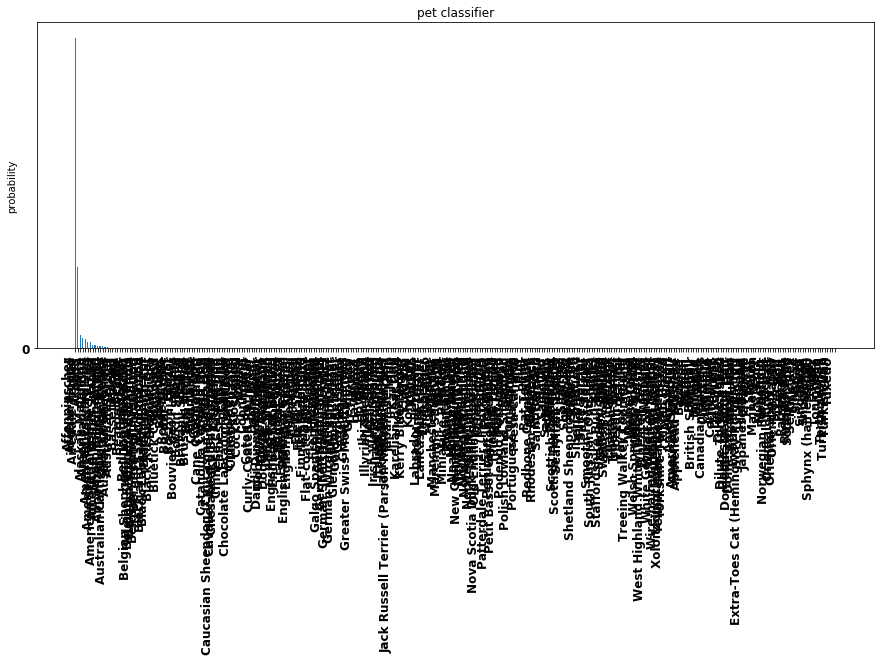

In [243]:
N = 307
img = image.load_img('classify/tiny.jpg', target_size=(256, 256))
preds = predict(model, img)

p =preds[preds.argsort()[-N:]]
p[::-1].sort()
#print(p)
labels = ( "Domestic Short Hair", "Domestic Medium Hair", "Tabby", "Domestic Long Hair"
        , "Siamese", "Persian", "Labrador Retriever", "Shih Tzu", "Poodle", "Terrier", "Golden Retriever",
        "Calico","German Shepherd Dog","American Shorthair","Spitz","Beagle","Rottweiler","Oriental Short Hair",
        "Bengal","Schnauzer","Miniature Pinscher","Jack Russell Terrier","Doberman Pinscher","Tuxedo","Cocker Spaniel",
        "Tortoiseshell","Dalmatian","Chihuahua","Husky","Border Collie","Bernese Mountain Dog")
labels = df2.BreedName.unique()

ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(8,8))
plt.imshow(np.asarray(img))

plt.figure(figsize=(15,6))
p1 = plt.bar(ind, p, width)



plt.ylabel('probability')
plt.title('pet classifier')
#plt.xticks(ind, labels)
plt.yticks(np.arange(0, 1))

plt.xticks(ind, labels, rotation=90, horizontalalignment='right', weight='bold', size='large')
plt.yticks(np.arange(0, 1), weight='bold', size='large')

#plt.gca().invert_xaxis()
#plt.xlim(32, 25)
plt.show()